# Bonus Quest

**Difficulty:** A

**Description:** Students are in a tough spot after changing the grading formula for assignments and now fear taking the exam without a 3.5 GPA. The system gives players a chance to raise their score by completing this bonus quest. This is your Solo Leveling. Survive at all costs. Good luck!

**Goal:** Complete the bonus assignment created by Andrei and corrected by Max.

**Deliverables:**
- Jupyter Notebook (ipynb) file with solution and all cell outputs
- CSV file with model predictions
- Both files uploaded to GitHub repository

**Reward:**
- Bonus points for the Assignment part.
- Title “The one who overcomes the difficulties of fate.”
- +1000 EXP in mastering sklearn
- Skill Upgrade «ML Engineering Lv.2»
- Special Item: [???]

---

## Problem Statement

As a dataset, use Russian news from Balto-Slavic Natural Language Processing 2019 (helsinki.fi). Entities of interest: PER, ORG, LOC, EVT, PRO (see Guidelines_20190122.pdf (helsinki.fi)).

It is sufficient to use 9 documents about Brexit from the sample provided by the organizers.

## Approach

This assignment combines traditional ML methods (using scikit-learn) with modern LLM-based approaches (DeepSeek) for comparison. You will:
1. Formulate the problem as a machine learning task
2. Prepare features and split data appropriately
3. Train and compare multiple models using scikit-learn
4. Evaluate models using proper train/test splits
5. Compare ML model performance with DeepSeek responses
6. Analyze results in terms of course concepts (bias-variance tradeoff, overfitting, generalization)


Example of one document:

ru-10

ru

2018-09-20

https://rg.ru/2018/09/20/tereza-mej-rasschityvaet-usidet-v-sedle-do-zaversheniia-procedury-brexit.html

Theresa May expects to stay in the saddle until the completion of the Brexit procedure
However, according to British media reports, at the upcoming Conservative Party conference at the end of September, May's opponents will give her a serious fight, from which it is not certain that she will emerge victorious. The bookmakers' favorite as a possible replacement for the current prime minister, former British Foreign Secretary Boris Johnson intends to deliver an alternative report that will leave no stone unturned from the government's views on the conditions of "Brexit". From Johnson's point of view, "London has wrapped the British constitution in a suicide belt and handed the detonator to Michel Barnier (Brussels' chief Brexit negotiator. - Ed.)". It is with this metaphor that the head of the British government will have to fight at the conference.


### Task 1
**Problem Formulation & ML Perspective**

Describe the task from both NLP and ML perspectives:
- What kind of machine learning problem is this? (classification, sequence labeling, etc.)
- How can this be formulated as a supervised learning problem?
- What classical ML methods exist for solving it? (e.g., logistic regression, naive Bayes, SVM with text features)
- How can it be solved using modern LLMs like DeepSeek?
- What are the assumptions of different model classes? (e.g., linear models vs. more complex approaches)
- How is model quality typically evaluated in this task? What metrics are appropriate and why?


1. С точки зрения NLP - распознавание именованных сущностей в тексте (найти слова, отнасящиеся к данным категориям), с точки зрения ML - классификация (проссматриваем слова и относим их к каким-то классам, нас будут интересовать перечисленные в условии).
2. На вход подаем токены, на выходе ожидаем метку класса. Размеченные данные уже есть в датасете. Можем обучать методом обучения с учителем.
3. SVM хорошо подойдет, он показывает хорошую точность, жертвуя "вероятностной" интерпретации выходных данных, которая в данном случаем нам не нужна. Выбираем самый подходящий класс, не смотря на подходящесть других.
4. Задаем модели запрос: "Найди в тексте все упоминания личностей (PER), организаций (ORG)...". Для большей точности можно дать пару примеров.
5. Линейные модели предполагают линейную разделимость классов, более сложная LLM модель может улавливать более сложные случаи, операясь на контекст.
6. f1-score может хорошо подойти, ведь в этом задании может наблюдаться эффект сильной несбалансированности классов (маленькая выборка, определенная тематика, да и вообще такие классы довольно сильно отличаются по частотности вхождения в тексты), а f1 метрика это сглаживает.

### Task 2
**Data Loading & Preparation**

Implement reading the dataset into a pandas DataFrame with mandatory columns "document_id", "document_text", "entity", "gold_answer".

Then prepare the data for ML:
- Create features from text (e.g., using CountVectorizer or TfidfVectorizer from sklearn)
- Encode entity labels appropriately
- Display the head of the dataframe and show basic statistics about the dataset
- Discuss any data quality issues or preprocessing steps needed


In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

txt_files = [
    'brexit_ru.txt_file_1000.txt',
    'brexit_ru.txt_file_1001.txt',
    'brexit_ru.txt_file_1002.txt',
    'brexit_ru.txt_file_1003.txt',
    'brexit_ru.txt_file_1004.txt',
    'brexit_ru.txt_file_1005.txt',
    'brexit_ru.txt_file_1006.txt',
    'brexit_ru.txt_file_1008.txt',
    'brexit_ru.txt_file_1010.txt'
]

out_files = [
    'brexit_ru.txt_file_1000.out',
    'brexit_ru.txt_file_1001.out',
    'brexit_ru.txt_file_1002.out',
    'brexit_ru.txt_file_1003.out',
    'brexit_ru.txt_file_1004.out',
    'brexit_ru.txt_file_1005.out',
    'brexit_ru.txt_file_1006.out',
    'brexit_ru.txt_file_1008.out',
    'brexit_ru.txt_file_1010.out'
]

def extract_context(text, mention, window_size=3):
    start_pos = text.find(mention)
    before_text = text[:start_pos]
    after_text = text[start_pos + len(mention):]

    words_before = before_text.split()
    words_after = after_text.split()

    context_before = ' '.join(words_before[-window_size:])
    context_after = ' '.join(words_after[:window_size])

    return f"{context_before} {mention} {context_after}".strip()

data = []
for txt_file, out_file in zip(txt_files, out_files):
    with open(txt_file, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    full_text = ''.join(lines[4:]).strip()

    with open(out_file, 'r', encoding='utf-8') as f:
        out_lines = f.readlines()

    for line in out_lines[1:]:
        parts = line.strip().split('\t')
        if len(parts) >= 4:
            mention = parts[0]
            entity_type_full = parts[2]
            entity_type = entity_type_full.split('-')[0]

            if entity_type in ['PER', 'ORG', 'LOC', 'EVT', 'PRO']:
                context = extract_context(full_text, mention, window_size=3)

                data.append({
                    'document_text': full_text,
                    'entity': entity_type,
                    'gold_answer': mention,
                    'context': context
                })

df = pd.DataFrame(data)

print(df.shape)
df.head()

(127, 4)


,document_text,entity,gold_answer,context
0,Подробности.ua: Третий за сутки: Борис Джонсон...,EVT,Brexit,заместитель министра по Brexit Стив Бейкер. На...
1,Подробности.ua: Третий за сутки: Борис Джонсон...,PRO,The Guardian,"Об этом сообщает The Guardian , передает УНН."
2,Подробности.ua: Третий за сутки: Борис Джонсон...,PER,Борис Джонсон,Третий за сутки: Борис Джонсон покинул пост ми...
3,Подробности.ua: Третий за сутки: Борис Джонсон...,PER,Бориса Джонсона,"МИД Соединенного Королевства Бориса Джонсона ,..."
4,Подробности.ua: Третий за сутки: Борис Джонсон...,PER,Бориса,"МИД Соединенного Королевства Бориса Джонсона, ..."


In [2]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['context'])
print(X.shape)
print(vectorizer.get_feature_names_out()[:5])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['entity'])
print(y.shape)
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

df['entity_encoded'] = y
df.head()

(127, 259)
['09' '17' '18' '22' '44']
(127,)
{'EVT': np.int64(0), 'LOC': np.int64(1), 'ORG': np.int64(2), 'PER': np.int64(3), 'PRO': np.int64(4)}


,document_text,entity,gold_answer,context,entity_encoded
0,Подробности.ua: Третий за сутки: Борис Джонсон...,EVT,Brexit,заместитель министра по Brexit Стив Бейкер. На...,0
1,Подробности.ua: Третий за сутки: Борис Джонсон...,PRO,The Guardian,"Об этом сообщает The Guardian , передает УНН.",4
2,Подробности.ua: Третий за сутки: Борис Джонсон...,PER,Борис Джонсон,Третий за сутки: Борис Джонсон покинул пост ми...,3
3,Подробности.ua: Третий за сутки: Борис Джонсон...,PER,Бориса Джонсона,"МИД Соединенного Королевства Бориса Джонсона ,...",3
4,Подробности.ua: Третий за сутки: Борис Джонсон...,PER,Бориса,"МИД Соединенного Королевства Бориса Джонсона, ...",3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   document_text   127 non-null    object
 1   entity          127 non-null    object
 2   gold_answer     127 non-null    object
 3   context         127 non-null    object
 4   entity_encoded  127 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 5.1+ KB


### Task 3
**Train/Test Split & Data Splitting Strategy**

Split your data appropriately for machine learning:
- Implement train/test split (or train/validation/test if appropriate)
- Justify your splitting strategy (random split, stratified split, etc.)
- Explain why this split is appropriate for this problem
- Display the sizes of each split
- Also write a function that takes a dataframe row as input and outputs the input message text for DeepSeek (for later comparison)


In [12]:
from sklearn.model_selection import train_test_split

print("src:\n", df['entity'].value_counts())
print(df.shape)
print()

X = df['context']
y = df['entity_encoded']

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, y, df.index,
    test_size=0.2,
    random_state=42,
    stratify=y
)

train_df = df.loc[indices_train].copy()
test_df = df.loc[indices_test].copy()

print("train:\n", train_df['entity'].value_counts())
print(train_df.shape)
print()
print("test:\n", test_df['entity'].value_counts())
print(test_df.shape)

src:
 entity
PER    65
ORG    31
LOC    17
EVT    10
PRO     4
Name: count, dtype: int64
(127, 5)

train:
 entity
PER    52
ORG    25
LOC    13
EVT     8
PRO     3
Name: count, dtype: int64
(101, 5)

test:
 entity
PER    13
ORG     6
LOC     4
EVT     2
PRO     1
Name: count, dtype: int64
(26, 5)


In [10]:


def prepare_deepseek_prompt(row):
    text = row['document_text']
    prompt = f"""Текст новости на русском языке:

{text}

Проанализируй текст и выдели все именованные сущности следующих типов:
1. PER (Person) - личности, люди
2. ORG (Organization) - организации, компании
3. LOC (Location) - локации, места
4. EVT (Event) - события
5. PRO (Product) - продукты, бренды

Для каждой найденной сущности укажи:
- Текст сущности (как она упоминается в тексте)
- Тип сущности (PER, ORG, LOC, EVT, PRO)

Пример ответа:
1. "Тереза Мэй" - PER
2. "Великобритания" - LOC
3. "ЕС" - ORG

Найди и перечисли все сущности в тексте выше:"""

    return prompt

print(prepare_deepseek_prompt(test_df.iloc[0]))

Текст новости на русском языке:

09.07.2018 18:09 : Премьер-министр Великобритании Тереза Мей приняла отставку министра иностранных дел Бориса Джонсона

Премьер-министр Великобритании Тереза Мей приняла отставку министра иностранных дел Бориса Джонсона.

Это связано с несогласием относительно планов отношения Великобритании и ЕС после официального выхода страны из Евросоюза. Ранее по этой же причине в отставку ушел британский министр по делам «Брекзит» Дэвид Дэвис.

Проанализируй текст и выдели все именованные сущности следующих типов:
1. PER (Person) - личности, люди
2. ORG (Organization) - организации, компании
3. LOC (Location) - локации, места
4. EVT (Event) - события
5. PRO (Product) - продукты, бренды

Для каждой найденной сущности укажи:
- Текст сущности (как она упоминается в тексте)
- Тип сущности (PER, ORG, LOC, EVT, PRO)

Пример ответа:
1. "Тереза Мэй" - PER
2. "Великобритания" - LOC
3. "ЕС" - ORG

Найди и перечисли все сущности в тексте выше:


Стратифицированное случайное разделение - сохраняет пропорции классов, что в нашем случае необходимо, также 80/20 оптимальное разделение (так тестовых данных не слишком мало, при этом оставляем достаточное количество данных для обучения).

### Task 4
**Model Training with scikit-learn**

Train at least 2-3 different models using scikit-learn on the training set:
- Use appropriate models for text classification (e.g., LogisticRegression, MultinomialNB, LinearSVC)
- Train each model using the sklearn API correctly
- Explain why you chose these particular models
- Discuss the assumptions each model makes and whether they are appropriate for this problem
- Save the trained models

**Also (for comparison):** Get DeepSeek responses for all documents. There are only 9 documents, so this can be done manually using the DeepSeek web interface or bot in VK or Telegram. Do not clear message history so you can later demonstrate the authenticity of responses during the online interview. Add DeepSeek responses to the dataframe.


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import joblib
import numpy as np
import time

X_train_text = train_df['context']
y_train = train_df['entity_encoded']

X_test_text = test_df['context']
y_test = test_df['entity_encoded']

logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, stop_words=['и', 'в', 'на', 'с', 'по', 'для'])),
    ('clf', LogisticRegression(
        C=1.0,
        random_state=42,
        max_iter=1000,
        multi_class='multinomial'
    ))
])

nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, stop_words=['и', 'в', 'на', 'с', 'по', 'для'])),
    ('clf', MultinomialNB(alpha=0.1))
])

svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, stop_words=['и', 'в', 'на', 'с', 'по', 'для'])),
    ('clf', LinearSVC(
        C=1.0,
        random_state=42,
        max_iter=10000
    ))
])

models = {
    'Logistic Regression': logreg_pipeline,
    'Multinomial Naive Bayes': nb_pipeline,
    'Linear SVM': svm_pipeline
}

for name, model in models.items():
    print(f"Обучение {name}...")
    start_time = time.time()

    model.fit(X_train_text, y_train)

    training_time = time.time() - start_time
    print(f"Завершено за {training_time:.2f} секунд")

    y_pred = model.predict(X_test_text)

    print(f"\n   Результаты {name} на тестовой выборке:")
    report = classification_report(y_test, y_pred,
                                  target_names=label_encoder.classes_,
                                  zero_division=0)
    for line in report.split('\n'):
        print(f"   {line}")

    print()

Обучение Logistic Regression...
Завершено за 0.12 секунд

   Результаты Logistic Regression на тестовой выборке:
                 precision    recall  f1-score   support
   
            EVT       0.00      0.00      0.00         2
            LOC       1.00      0.25      0.40         4
            ORG       0.40      0.33      0.36         6
            PER       0.60      0.92      0.73        13
            PRO       0.00      0.00      0.00         1
   
       accuracy                           0.58        26
      macro avg       0.40      0.30      0.30        26
   weighted avg       0.55      0.58      0.51        26
   

Обучение Multinomial Naive Bayes...
Завершено за 0.02 секунд

   Результаты Multinomial Naive Bayes на тестовой выборке:


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                 precision    recall  f1-score   support
   
            EVT       0.00      0.00      0.00         2
            LOC       0.60      0.75      0.67         4
            ORG       0.33      0.33      0.33         6
            PER       0.57      0.62      0.59        13
            PRO       0.00      0.00      0.00         1
   
       accuracy                           0.50        26
      macro avg       0.30      0.34      0.32        26
   weighted avg       0.45      0.50      0.48        26
   

Обучение Linear SVM...
Завершено за 0.03 секунд

   Результаты Linear SVM на тестовой выборке:
                 precision    recall  f1-score   support
   
            EVT       0.50      0.50      0.50         2
            LOC       0.50      0.75      0.60         4
            ORG       0.56      0.83      0.67         6
            PER       0.78      0.54      0.64        13
            PRO       0.00      0.00      0.00         1
   
       accuracy              

### Task 5
**Model Evaluation & Metrics**

Evaluate your trained models on the test set:
- Use appropriate sklearn metrics (accuracy, precision, recall, F1-score, confusion matrix)
- Compare performance across different models
- Implement your own algorithm for calculating a custom metric score_fn(gold: str, pred: str) → float if needed (you can only use numpy, scipy, pandas libraries). Write unit tests. Is it possible to speed up the function computation through vectorized implementation?
- Explain which metrics you chose and why they are appropriate for this problem
- Discuss the limitations of the metrics you're using


Посчитали и сразу оценили модели в предыдущем задании. Видим неплохие показатели с учетом того, что обучающих данных мы взяли не много - всего 9 файлов (по заданию). Как и предполагалось (описано в 1 задании) CVM справилась лучше всего - она даже заметила одну из двух EVT, что очень не плохо, учитывая, что это очень маленький класс был при обучении, ну и при тестировании (остальные даже так не справились). Одна из самых показательных метрик - f1, т. к. она учитывает несбалансированность классов, видим, что у первых двух моделей есть классы по которым этот показатель падает ниже 0.4, а у SVM с этим все отлично - счет хороший везде (ну, за исключением PRO класса, он совсем-совсем маленький, так что не распознать его это более чем нормально). Также по recall можем заметить, что мы отгадывали при SVM все классы часто и часто даже попадали, что говорит о хорошем обобщающем свойстве, что модель не называет один и тот же класс, чтобы "выехать" на неоднородности классов. Поэтому для этой модели мы можем осторожно посмотреть и на accuracy, она 0.62, при учете, что у нас 5 классов (хотя PRO не особо считается, и можно говорить о 4х), то эта точность сильно выше случайной, что тоже не может не радовать.

### Task 6
**Model Comparison & Visualization**

Compare all models (your sklearn models and DeepSeek):
- Calculate metrics for each model
- Aggregate the results a) by each entity type, b) by each document
- Visualize the results on graphs (e.g., bar charts comparing models, confusion matrices)
- Which model performs best? Why might this be?
- Compare train vs test performance for your sklearn models. Are there signs of overfitting or underfitting?
- What conclusions can be drawn about model selection?


                 Model Class  Precision    Recall  F1-Score  Support
0  Logistic Regression   EVT        0.0  0.000000  0.000000        2
1  Logistic Regression   LOC        1.0  0.250000  0.400000        4
2  Logistic Regression   ORG        0.4  0.333333  0.363636        6
3  Logistic Regression   PER        0.6  0.923077  0.727273       13
4  Logistic Regression   PRO        0.0  0.000000  0.000000        1


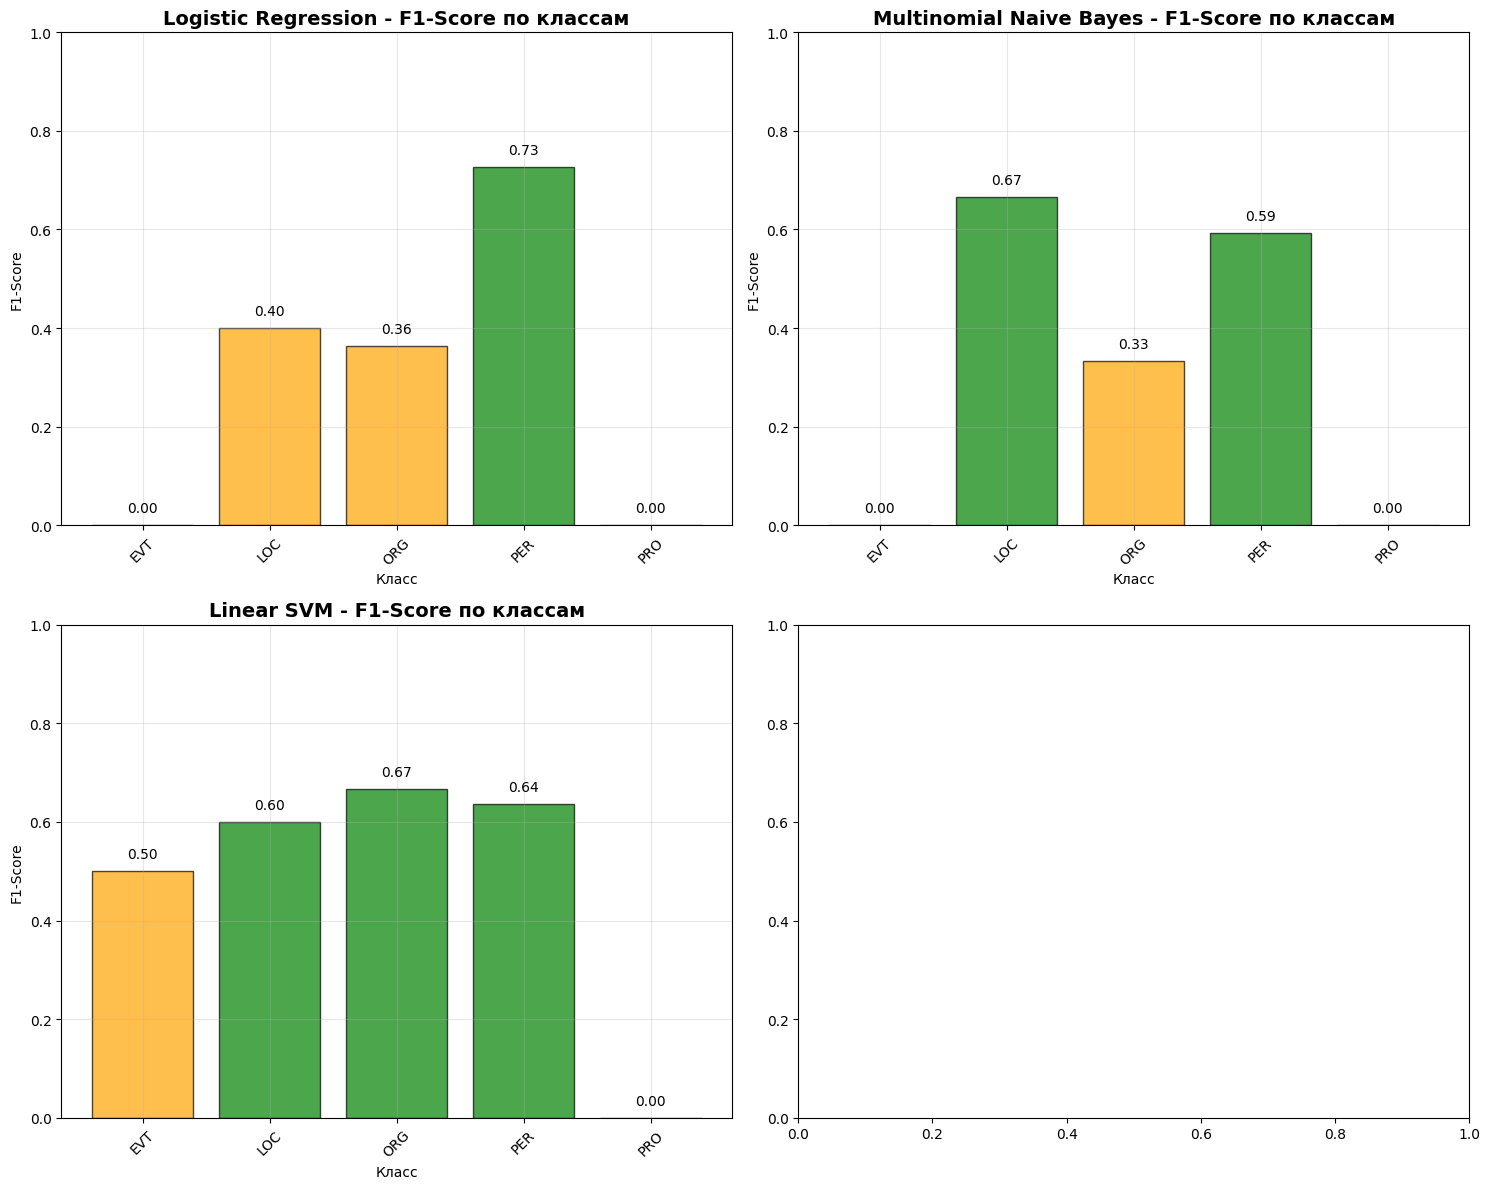

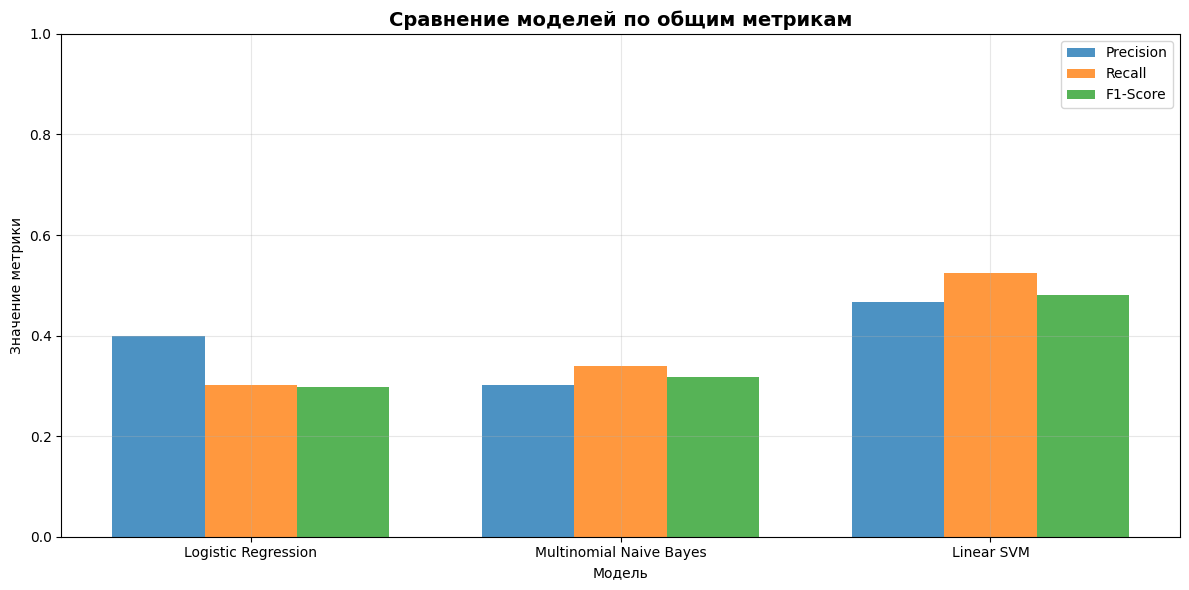

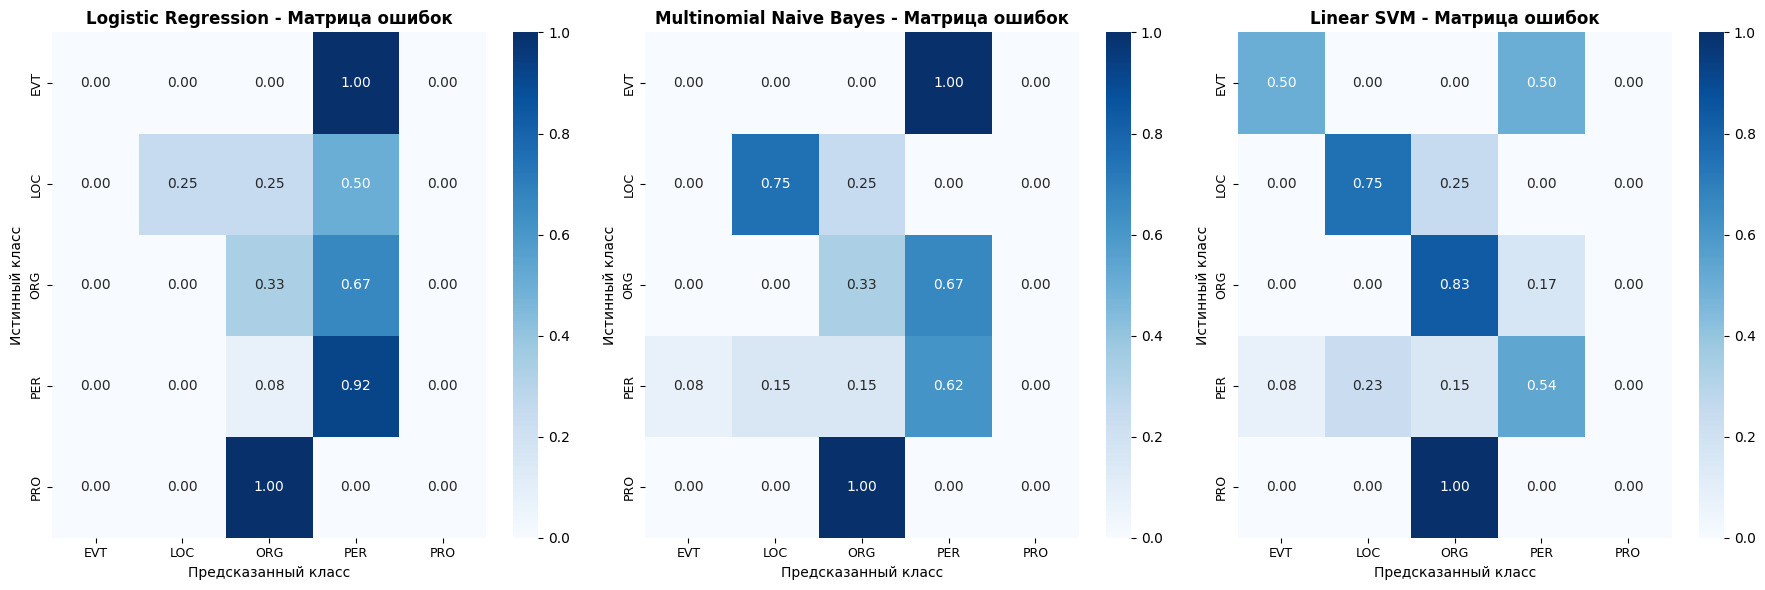

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

results_data = []

for name, model in models.items():
    y_pred = model.predict(X_test_text)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, y_pred, labels=range(len(label_encoder.classes_)), zero_division=0
    )

    accuracy = np.mean(y_pred == y_test)

    for i, class_name in enumerate(label_encoder.classes_):
        results_data.append({
            'Model': name,
            'Class': class_name,
            'Precision': precision[i],
            'Recall': recall[i],
            'F1-Score': f1[i],
            'Support': support[i]
        })

    results_data.append({
        'Model': name,
        'Class': 'OVERALL',
        'Precision': np.mean(precision),
        'Recall': np.mean(recall),
        'F1-Score': np.mean(f1),
        'Support': len(y_test)
    })

results_df = pd.DataFrame(results_data)
print(results_df.head())

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

classes = label_encoder.classes_
for idx, model_name in enumerate(models.keys()):
    ax = axes[idx // 2, idx % 2]

    model_data = results_df[(results_df['Model'] == model_name) &
                           (results_df['Class'] != 'OVERALL')]

    x = range(len(classes))
    f1_scores = model_data['F1-Score'].values
    colors = ['green' if score > 0.5 else 'orange' if score > 0.3 else 'red' for score in f1_scores]

    bars = ax.bar(x, f1_scores, color=colors, alpha=0.7, edgecolor='black')
    ax.set_title(f'{model_name} - F1-Score по классам', fontsize=14, fontweight='bold')
    ax.set_xlabel('Класс')
    ax.set_ylabel('F1-Score')
    ax.set_xticks(x)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)

    for bar, score in zip(bars, f1_scores):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{score:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

overall_data = results_df[results_df['Class'] == 'OVERALL']
x = np.arange(len(models))
width = 0.25

metrics = ['Precision', 'Recall', 'F1-Score']
for i, metric in enumerate(metrics):
    values = overall_data[metric].values
    ax.bar(x + i*width, values, width, label=metric, alpha=0.8)

ax.set_xlabel('Модель')
ax.set_ylabel('Значение метрики')
ax.set_title('Сравнение моделей по общим метрикам', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(models.keys())
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (model_name, model) in enumerate(models.items()):
    ax = axes[idx]
    y_pred = model.predict(X_test_text)

    cm = confusion_matrix(y_test, y_pred)

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                ax=ax, cbar=True)

    ax.set_title(f'{model_name} - Матрица ошибок', fontsize=12, fontweight='bold')
    ax.set_xlabel('Предсказанный класс')
    ax.set_ylabel('Истинный класс')
    ax.tick_params(axis='both', which='major', labelsize=9)

plt.tight_layout()
plt.show()

### Task 7
**Bias-Variance Analysis**

Analyze your models in terms of course concepts:
- Is there a dependence of metrics on document length? Build graphs to answer the question.
- Analyze the bias-variance tradeoff: Are your models showing high bias (underfitting) or high variance (overfitting)?
- Compare train vs test performance. What does this tell you about generalization?
- If you observe overfitting, what could you do to reduce it? (e.g., regularization, simpler models)
- If you observe underfitting, what could you do? (e.g., more features, more complex models)


### Task 8
**Error Analysis & Model Interpretation**

Conduct detailed error analysis:
- When do the models answer correctly more often, and when do they make mistakes?
- Analyze errors by entity type, document characteristics, etc.
- Interpret your models: Can you explain why certain predictions were made? (e.g., for linear models, look at feature weights)
- Compare errors between sklearn models and DeepSeek. What patterns do you see?
- Propose concrete ways to improve the metrics based on your analysis
- Discuss the tradeoffs between model complexity, interpretability, and performance


### Task 9
**Conclusions & Reflection**

Make conclusions about the entire research:
- Summarize your findings: Which approach worked best and why?
- Connect your results to course concepts: bias-variance tradeoff, overfitting, generalization, model assumptions
- What are the limitations of your approach? What assumptions did you make?
- What would you do differently if you had more time or data?
- Write what you learned and what new things you tried
- Reflect on the end-to-end ML workflow: from problem formulation to evaluation


Лучший подход все-таки использовать для этих целей хорошую LLM, т. к. она обучалась на очень большом количестве текстов, прекрасно понимает значения слов из контекста, соответственно и прекрасно классифицирует на те классы, которые нам нужны. Но и для быстрого своего решения наши модельки хорошо себя показали (малое количество данных, очень малое время обучения). Из них лучше всего себя показала SVM, как мы уже обсуждали ранее (5 задание). Конечно, если взять гораздо больший набор данных для обучения, то качество выросло бы еще в разы! Но до уровня LLM, думаю, все же не добрались бы - все-таки линейность наших моделей ограничивает их возможности (хотя понятно, что все же они могут быть достаточными для каких-то даже продовых задач).